<a href="https://colab.research.google.com/github/Kiarashmo/Stroke-Patient-Motor-Imagery-Classification-System-by-Utilizing-Transfer-Learning/blob/main/Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utils

In [ ]:
!pip install torcheeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.7 MB/s eta 0:00:00
  Created wheel for torcheeg: filename=torcheeg-1.0.11-py3-none-any.whl size

In [ ]:
from torcheeg.utils import plot_raw_topomap, plot_feature_topomap, plot_signal, plot_3d_tensor, plot_2d_tensor, plot_adj_connectivity
import numpy as np
import mne

### Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset class

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import numpy as np

class EEGDataset(Dataset):
    def __init__(self, data_folder_path: str, subjects: list, shuffle: bool = True):
      """
      `data_folder_path` should have following structure:
        - subject001.npz
        - subject001.npz
        ...

      Each npz file contains both "data" and "labels" for one subject.
      """

      print("----")
      print(f"Creating dataset for {len(subjects)} subjects...")
      data_list = []
      labels_list = []

      for i in subjects:
        data_and_labels = np.load(f"{data_folder_path}/subject{i:03}.npz")

        data = data_and_labels['data']
        data = data.reshape((data.shape[0], 1, *data.shape[1:])) # N C W -> N 1 C W

        labels = data_and_labels['labels']
        data_list.append(data)
        labels_list.append(labels)

      self.data = torch.tensor(np.concatenate(data_list).astype(np.float32))
      self.labels = torch.tensor(np.concatenate(labels_list).astype(np.long))

      if shuffle:
        idx = torch.randperm(self.data.shape[0])
        self.data = self.data[idx]
        self.labels = self.labels[idx]

      print("Dataset created:")
      print("Data shape:", self.data.shape)
      print("Labels shape:", self.labels.shape)
      print("----")


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


## Setup parameters and data

In [ ]:
channels_for_plotting = [
 'F7',
 'F3',
 'Fz',
 'F4',
 'F8',
 'FT7',
 'FC3',
 'FCz',
 'Fc4',
 'Ft8',
 'T7',
 'T8',
 'TP7',
 'TP8',
 'CP3',
 'CP4',
 'C3',
 'C4',
 'Cz',
]

healthy_channel_mapping = {
 'F7..': 'F7',
 'F3..': 'F3',
 'Fz..': 'Fz',
 'F4..': 'F4',
 'F8..': 'F8',
 'Ft7.': 'FT7',
 'Fc3.': 'FC3',
 'Fcz.': 'FCz',
 'Fc4.': 'FC4',
 'Ft8.': 'FT8',
 'T7..': 'T7',
 'T8..': 'T8',
 'Tp7.': 'TP7',
 'Tp8.': 'TP8',
 'Cp3.': 'CP3',
 'Cp4.': 'CP4',
 'C3..': 'C3',
 'C4..': 'C4',
 'Cz..': 'Cz',
}

channels_for_healthy = list(healthy_channel_mapping.keys())

stroke_channel_mapping = {
'F7': 'F7',
'F3': 'F3',
'Fz': 'Fz',
'F4': 'F4',
'F8': 'F8',
'FT7': 'FT7',
'FC3': 'FC3',
'FCz': 'FCz',
'FC4': 'FC4',
'FT8': 'FT8',
'T3': 'T7',
'T4': 'T8',
'TP7': 'TP7',
'TP8': 'TP8',
'CP3': 'CP3',
'CP4': 'CP4',
'C3': 'C3',
'C4': 'C4',
'Cz': 'Cz'
}

channels_for_stroke = list(stroke_channel_mapping.keys())

sampling_rate = 160


## Paths

In [ ]:
healthy_base_path = '/content/drive/MyDrive/NMA2023_DL/Healthy_Dataset'
healthy_raw_data_path = f'{healthy_base_path}/raw/'
healthy_processed_data_path = f'{healthy_base_path}/mi_channels/'

stroke_base_path = '/content/drive/MyDrive/NMA2023_DL/Stroke_Dataset'
stroke_raw_data_path = f'{stroke_base_path}/edffile/'
stroke_processed_data_path = f'{stroke_base_path}/mi_channels/'
stroke_preprocessed_data_path = f'{stroke_base_path}/mi_channels/Filtered/'

montage_file_raw = "/content/drive/MyDrive/NMA2023_DL/Stroke_Dataset/task-motor-imagery_electrodes.tsv"
montage_file = "/content/drive/MyDrive/NMA2023_DL/Stroke_Dataset/task-motor-imagery_electrodes-unit-m.tsv"

In [ ]:
# Fix montage_file
import pandas as pd
mn = pd.read_csv(montage_file_raw, "\t")
mn['xx'] = mn['X'] / 10
mn['yy'] = mn['Y'] / 10
mn['Z'] /= 10

# Rotate left 90 degrees
mn['X'] = - mn['yy']
mn['Y'] = mn['xx']

mn.to_csv(montage_file, "\t", index=False)

# s_montage = mne.channels.read_custom_montage(montage_file)
# s_montage.plot()
# print()

<ipython-input-7-8ff2e2865a27>:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  mn = pd.read_csv(montage_file_raw, "\t")


## Raw EDF Plots

### Edf info

In [ ]:
def get_edf_file(raw_data_path, subject, trial=None, healthy=True):
  i = subject
  j = trial

  # Set trial path
  if healthy:
    trial_path = f'{raw_data_path}/S{i:03}/S{i:03}R{j:02}.edf'
    my_chan = channels_for_healthy
  else:
    trial_path = f'{raw_data_path}/sub-{i:02}/eeg/sub-{i:02}_task-motor-imagery_eeg.edf'
    my_chan = channels_for_stroke

  # Load data
  if my_chan:
    edf_data = mne.io.read_raw_edf(trial_path, verbose='WARNING', include=my_chan, preload=True)
    edf_data.reorder_channels(my_chan)
  else:
    edf_data = mne.io.read_raw_edf(trial_path, verbose='WARNING', preload=True)


  # Rename channels and Set montage
  if healthy:
    edf_data.rename_channels(healthy_channel_mapping)
    edf_data.set_montage('standard_1020') # It is actually 1010 but this seems to be working
  else:
    s_montage = mne.channels.read_custom_montage(montage_file)
    edf_data.set_montage(s_montage)

  print("---------------")
  print(f'Edf data info for {"healthy" if healthy else "storke"} subjects:')
  print("datapath:", raw_data_path)
  print(edf_data.info)
  return edf_data

In [ ]:
h_edf = get_edf_file(healthy_raw_data_path, subject=1, trial=4)
s_edf = get_edf_file(stroke_raw_data_path, subject=1, healthy=False)

---------------
Edf data info for healthy subjects:
datapath: /content/drive/MyDrive/NMA2023_DL/Healthy_Dataset/raw/
<Info | 8 non-empty values
 bads: []
 ch_names: F7, F3, Fz, F4, F8, FT7, FC3, FCz, FC4, FT8, T7, T8, TP7, TP8, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 19
 projs: []
 sfreq: 160.0 Hz
>
---------------
Edf data info for storke subjects:
datapath: /content/drive/MyDrive/NMA2023_DL/Stroke_Dataset/edffile/
<Info | 8 non-empty values
 bads: []
 ch_names: F7, F3, Fz, F4, F8, FT7, FC3, FCz, FC4, FT8, T3, T4, TP7, TP8, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2022-12-01 18:58:12 UTC
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>


In [ ]:
# By setting montage, we now have `digitized points` in both edf files
# which can be used for plotting
h_edf.info['dig']

[<DigPoint |        LPA : (-82.5, -0.0, 0.0) mm     : head frame>,
 <DigPoint |     Nasion : (0.0, 114.0, 0.0) mm      : head frame>,
 <DigPoint |        RPA : (82.5, 0.0, -0.0) mm      : head frame>,
 <DigPoint |    EEG #16 : (-71.9, 73.1, 25.8) mm    : head frame>,
 <DigPoint |    EEG #18 : (-51.8, 86.7, 78.7) mm    : head frame>,
 <DigPoint |    EEG #20 : (-1.2, 93.3, 102.6) mm    : head frame>,
 <DigPoint |    EEG #22 : (50.3, 87.4, 77.3) mm     : head frame>,
 <DigPoint |    EEG #24 : (71.4, 74.5, 25.1) mm     : head frame>,
 <DigPoint |    EEG #27 : (-82.5, 44.8, 27.7) mm    : head frame>,
 <DigPoint |    EEG #29 : (-61.9, 57.1, 93.8) mm    : head frame>,
 <DigPoint |    EEG #31 : (-1.3, 63.5, 126.6) mm    : head frame>,
 <DigPoint |    EEG #33 : (60.6, 57.7, 93.8) mm     : head frame>,
 <DigPoint |    EEG #35 : (80.1, 45.6, 27.4) mm     : head frame>,
 <DigPoint |    EEG #38 : (-86.0, 14.9, 31.2) mm    : head frame>,
 <DigPoint |    EEG #40 : (-67.1, 23.4, 104.5) mm   : head fra

In [ ]:
s_edf.info['dig']

[<DigPoint |        LPA : (-100.0, 0.0, 0.0) mm     : head frame>,
 <DigPoint |     Nasion : (0.0, 100.0, 0.0) mm      : head frame>,
 <DigPoint |        RPA : (100.0, 0.0, 0.0) mm      : head frame>,
 <DigPoint |     EEG #3 : (0.0, 71.9, 69.5) mm      : head frame>,
 <DigPoint |     EEG #4 : (-54.5, 67.3, 50.0) mm    : head frame>,
 <DigPoint |     EEG #5 : (54.5, 67.3, 50.0) mm     : head frame>,
 <DigPoint |     EEG #6 : (-80.9, 58.7, -3.5) mm    : head frame>,
 <DigPoint |     EEG #7 : (80.9, 58.7, -3.5) mm     : head frame>,
 <DigPoint |     EEG #8 : (0.0, 39.1, 92.1) mm      : head frame>,
 <DigPoint |     EEG #9 : (-67.6, 36.0, 64.3) mm    : head frame>,
 <DigPoint |    EEG #10 : (67.6, 36.0, 64.3) mm     : head frame>,
 <DigPoint |    EEG #11 : (-95.0, 30.9, -3.5) mm    : head frame>,
 <DigPoint |    EEG #12 : (95.0, 30.9, -3.5) mm     : head frame>,
 <DigPoint |    EEG #13 : (0.0, 0.0, 100.0) mm      : head frame>,
 <DigPoint |    EEG #14 : (-71.9, 0.0, 69.5) mm     : head fra

Healthy montage:


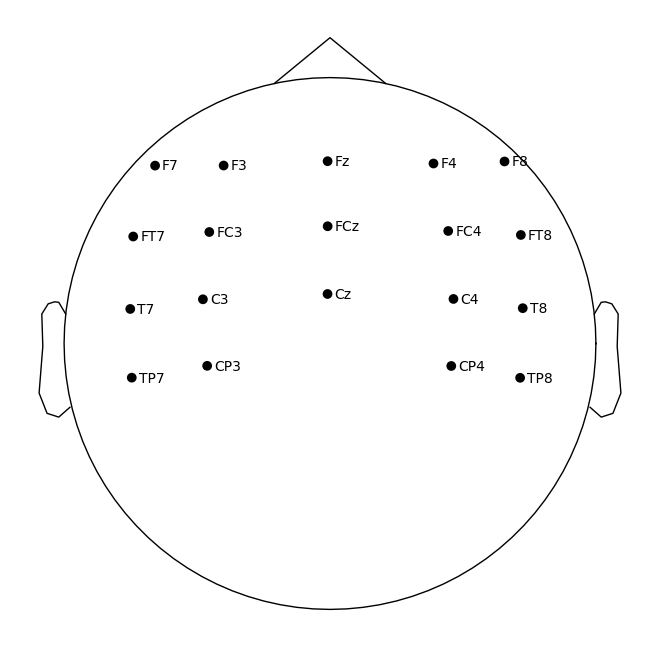


Stroke montage:


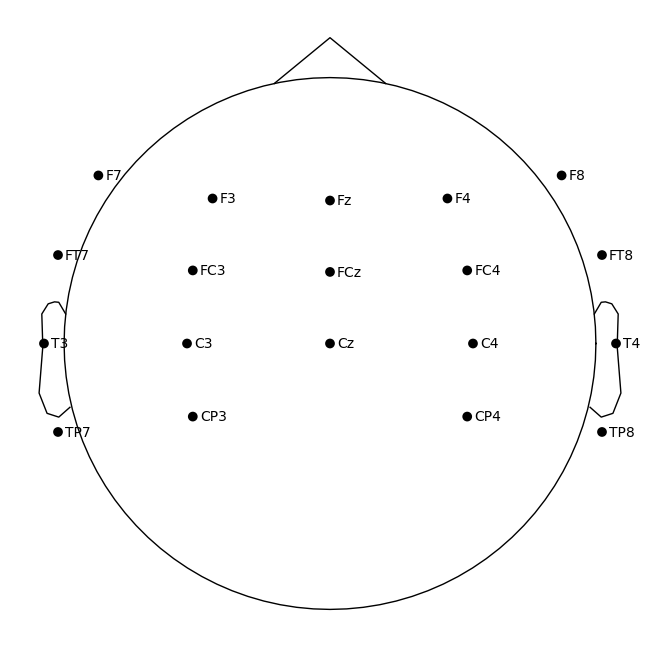

In [ ]:
print("Healthy montage:")
h_edf.get_montage().plot()
print()
print("Stroke montage:")
s_edf.get_montage().plot()
print()

In [ ]:
h_edf.describe()

<RawEDF | S001R04.edf, 19 x 20000 (125.0 s), ~2.9 MB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  F7    EEG   µV      -323.00     -41.00      -3.00      37.00     331.00
 1  F3    EEG   µV      -242.00     -37.00      -2.00      34.00     280.00
 2  Fz    EEG   µV      -222.00     -37.00      -1.00      34.00     264.00
 3  F4    EEG   µV      -201.00     -32.00      -2.00      30.00     241.00
 4  F8    EEG   µV      -175.00     -35.00      -5.00      27.00     260.00
 5  FT7   EEG   µV      -225.00     -37.00      -3.00      32.00     241.00
 6  FC3   EEG   µV      -213.00     -34.00       2.00      37.00     245.00
 7  FCz   EEG   µV      -201.00     -35.00       2.50      40.00     241.00
 8  FC4   EEG   µV      -183.00     -29.00       1.00      31.00     183.00
 9  FT8   EEG   µV      -168.00     -25.00      -2.00      21.00     155.00
10  T7    EEG   µV      -199.00     -31.00       1.00      35.00     225.00
11  T8    EEG   µV   

In [ ]:
s_edf.describe()

<RawEDF | sub-01_task-motor-imagery_eeg.edf, 19 x 160000 (320.0 s), ~23.2 MB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  F7    EEG   µV      -109.28      -4.11       1.17       6.43      87.58
 1  F3    EEG   µV       -68.90      -3.60       0.61       4.67      64.09
 2  Fz    EEG   µV       -60.93      -3.68       0.44       4.40      52.55
 3  F4    EEG   µV       -74.02      -3.50       0.51       4.37      52.77
 4  F8    EEG   µV       -96.90      -4.26       0.57       5.25      63.33
 5  FT7   EEG   µV       -75.11      -3.99       0.25       4.32      64.74
 6  FC3   EEG   µV       -77.35      -3.08       0.34       3.64      76.96
 7  FCz   EEG   µV       -52.17      -2.74       0.10       2.90      44.46
 8  FC4   EEG   µV       -59.80      -3.03       0.13       3.23      50.60
 9  FT8   EEG   µV       -62.14      -4.37      -0.08       4.25      63.07
10  T3    EEG   µV       -71.77      -3.59       0.07       3.77      72.

### PSD plotting

In [ ]:
def plot_psd_and_time(raw):
  raw.compute_psd(fmax=80).plot(picks="data", exclude="bads")
  raw.plot(start=0, duration=5, n_channels=len(channels_for_plotting))
  raw.plot(start=0, duration=300, scalings=1e-3/5)

Healthy data psd:


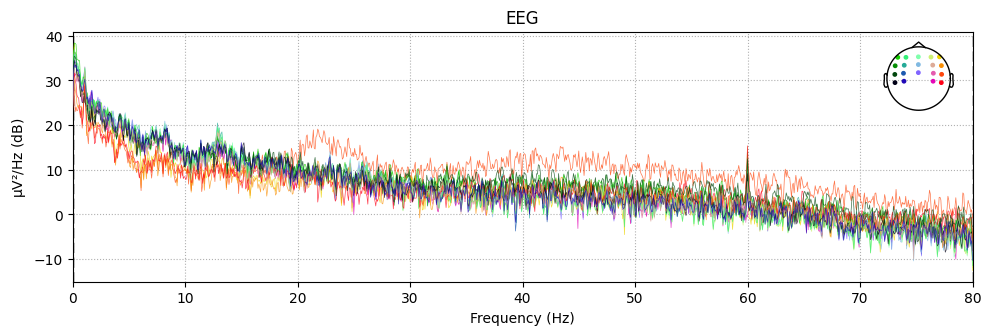

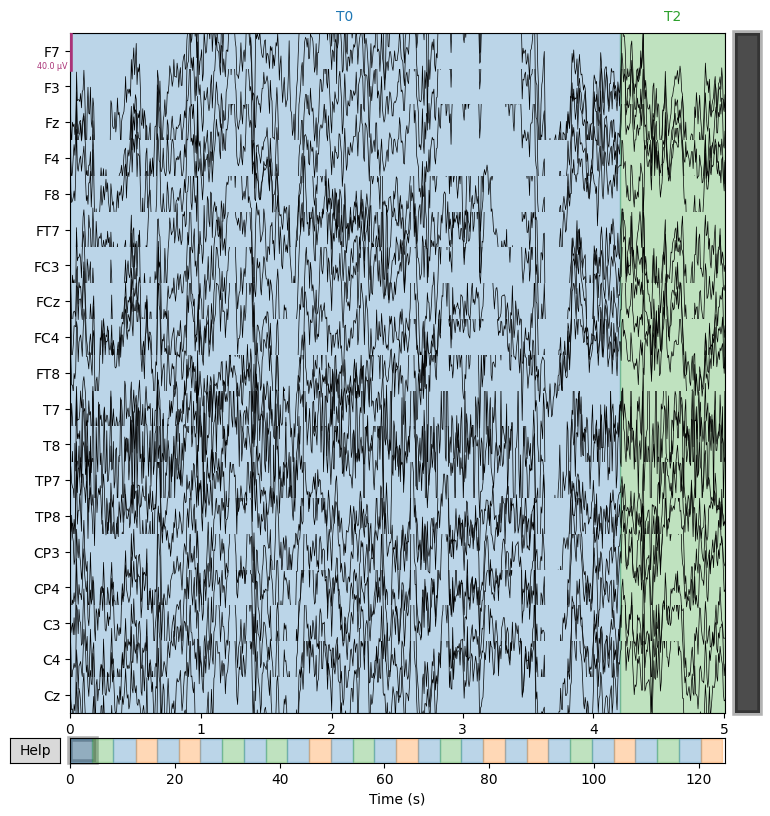

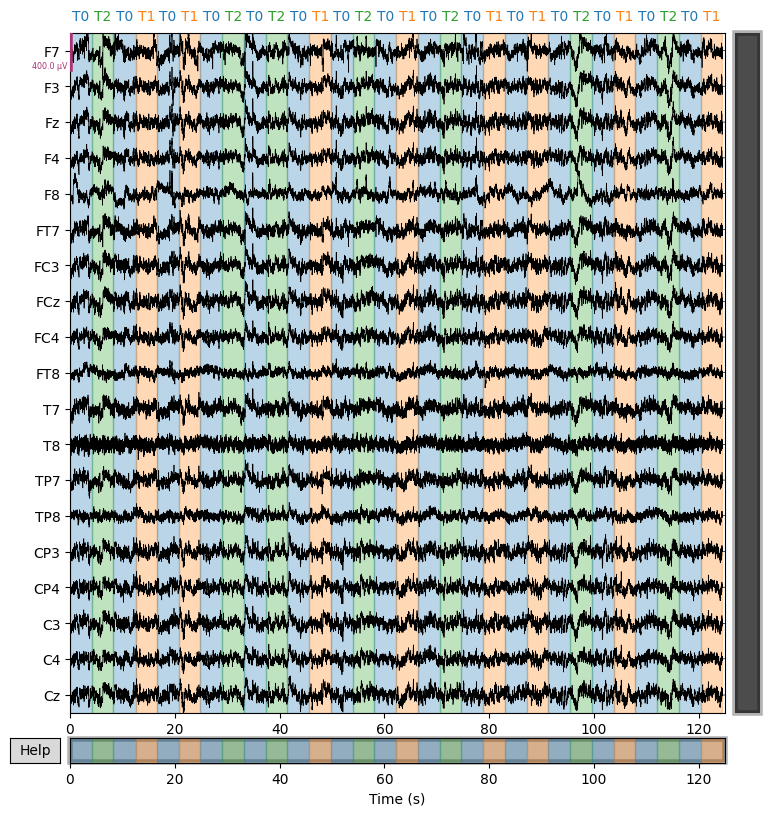

In [ ]:
print("Healthy data psd:")
plot_psd_and_time(h_edf)

Stroke data psd:


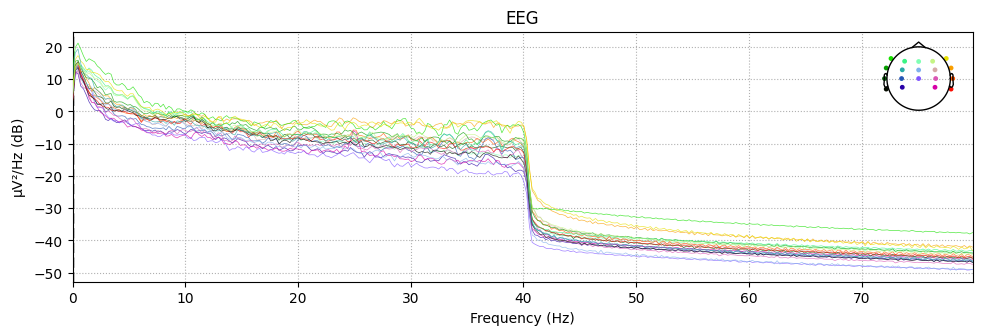

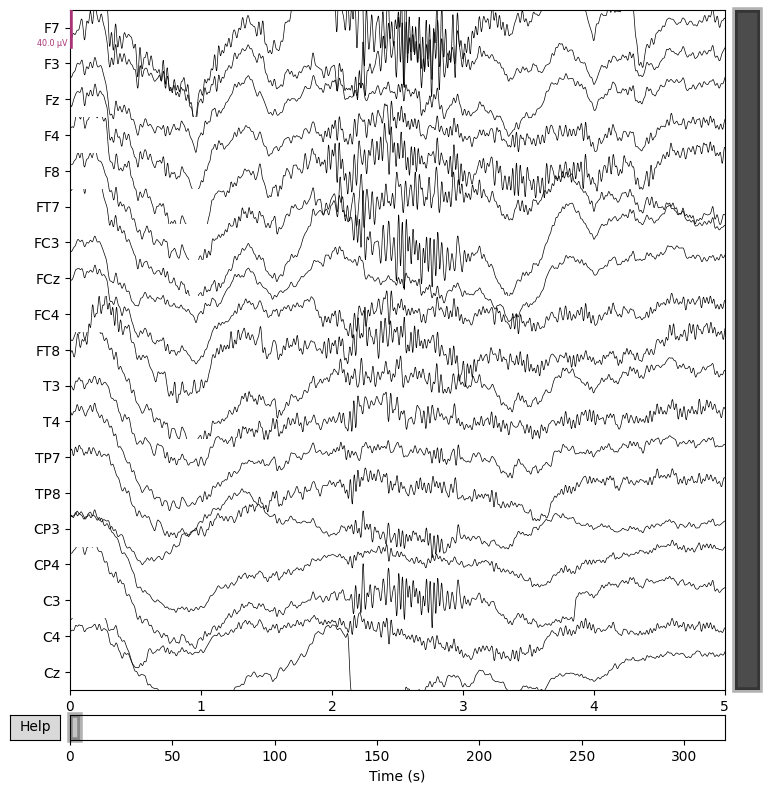

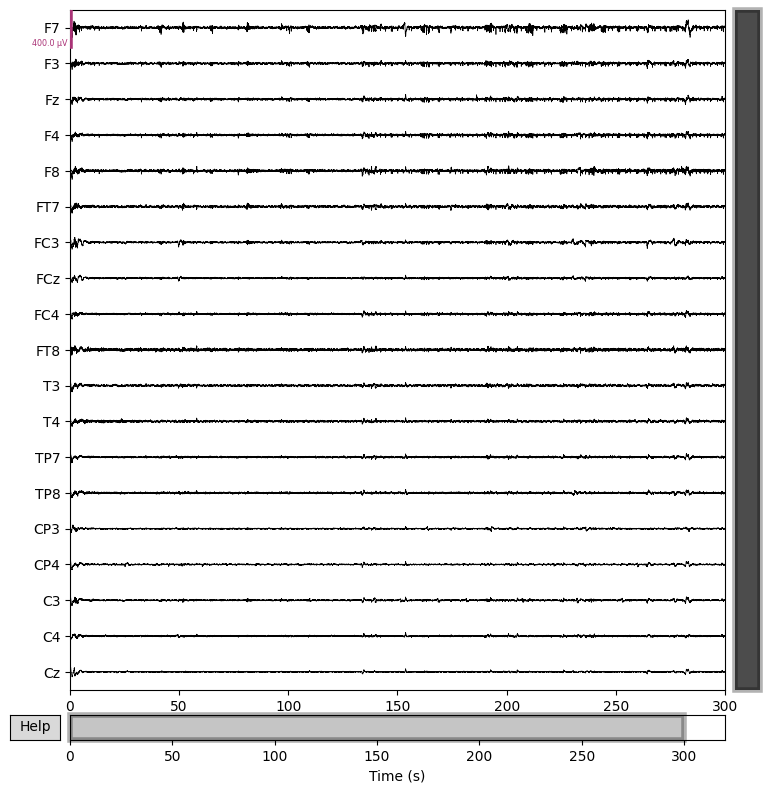

In [ ]:
print("Stroke data psd:")
plot_psd_and_time(s_edf)

### Plot data with referencing

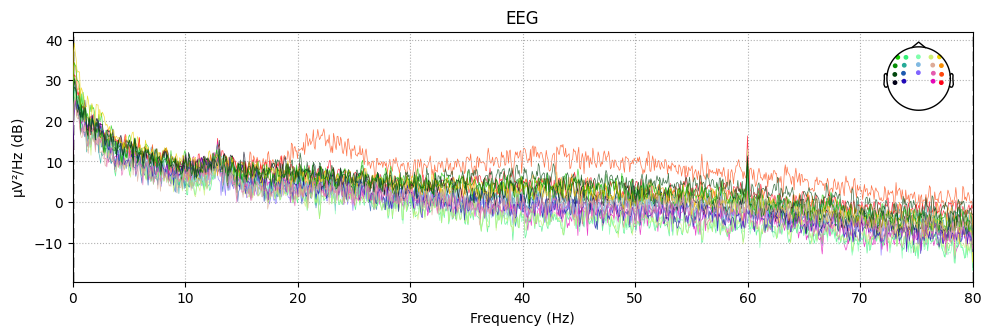

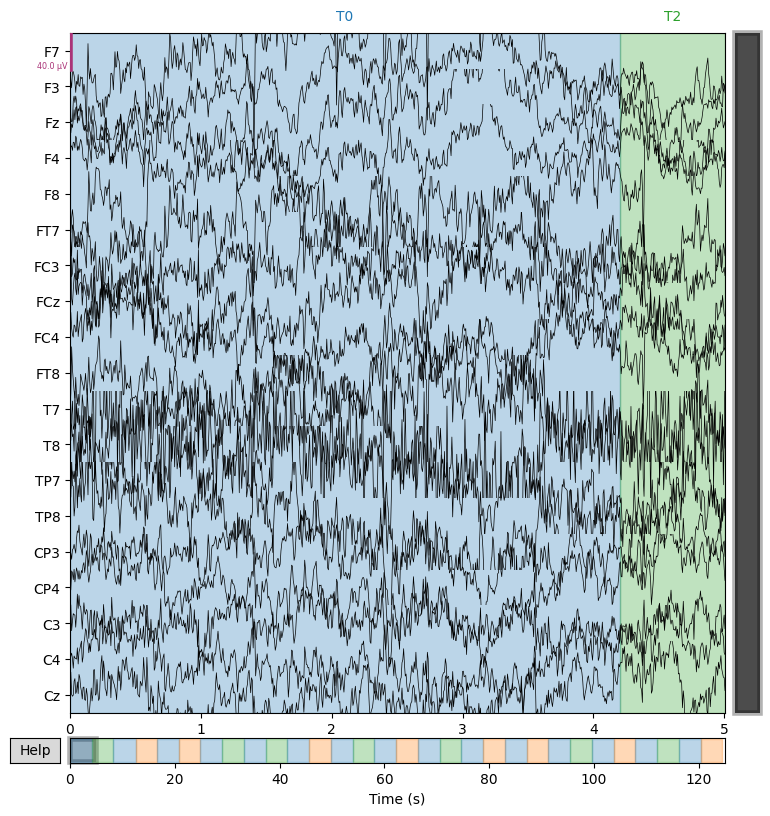

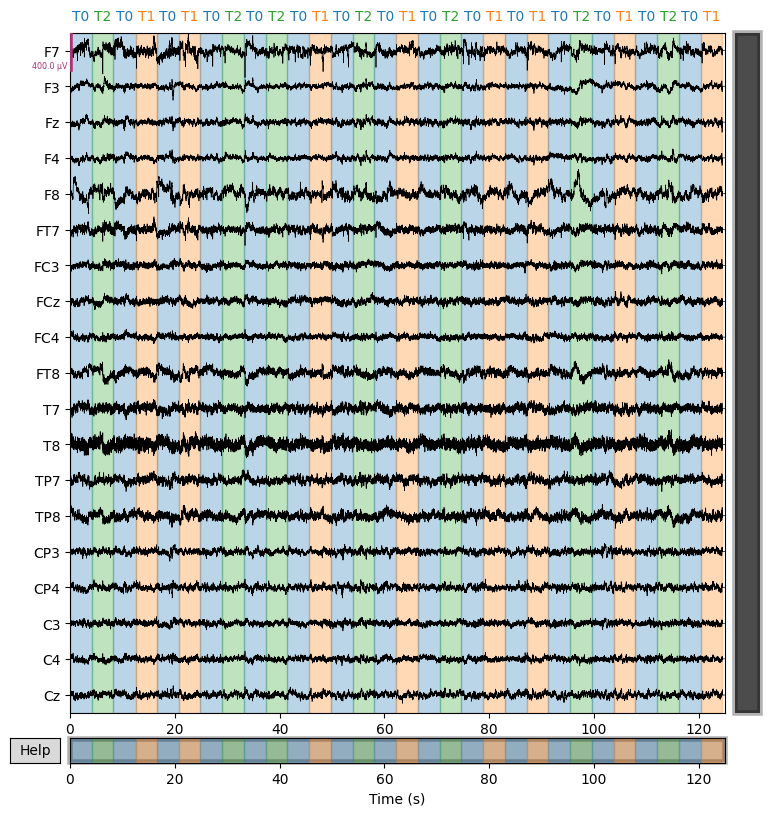

In [ ]:
h2_edf = h_edf.copy().set_eeg_reference(ref_channels='average')
plot_psd_and_time(h2_edf)

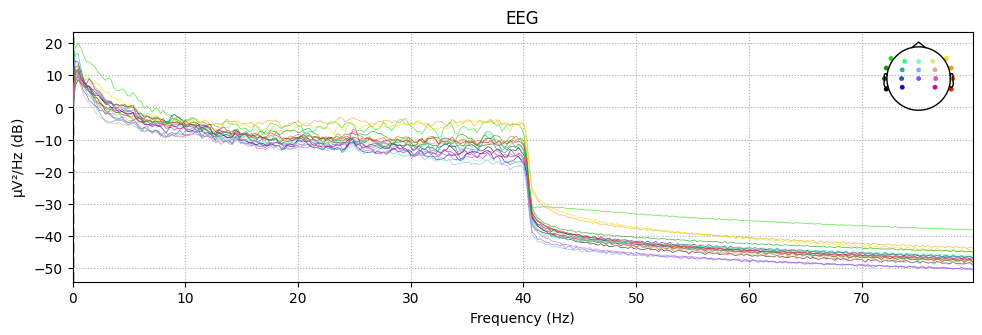

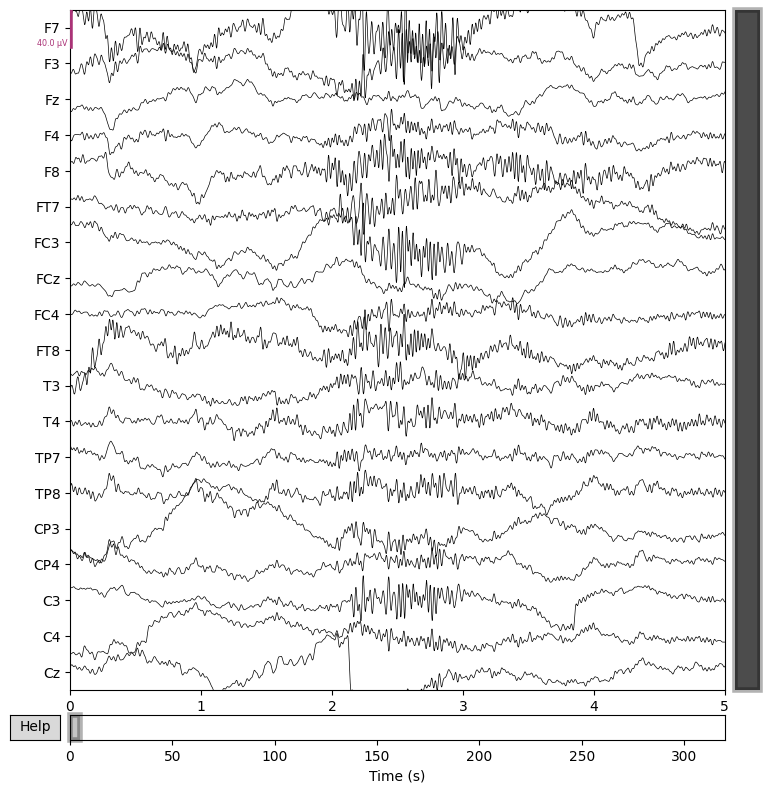

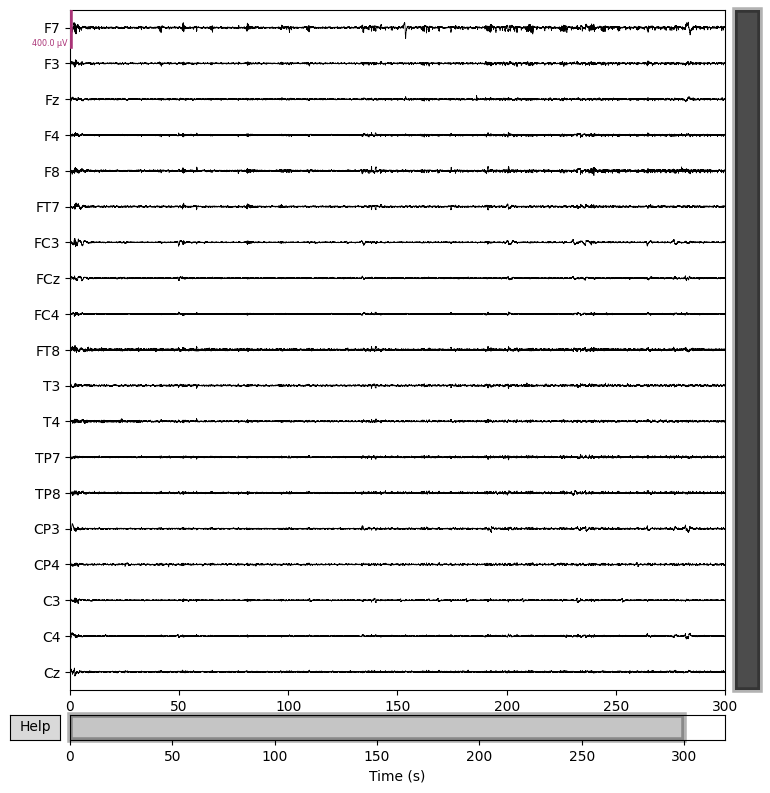

In [ ]:
s2_edf = s_edf.copy().set_eeg_reference(ref_channels='average')
plot_psd_and_time(s2_edf)

### Plot filtered data

In [ ]:
h_edf.load_data()
s_edf.load_data()

In [ ]:
# Filter settings
low_cut = 5
hi_cut  = 40

Healthy filtered data psd:


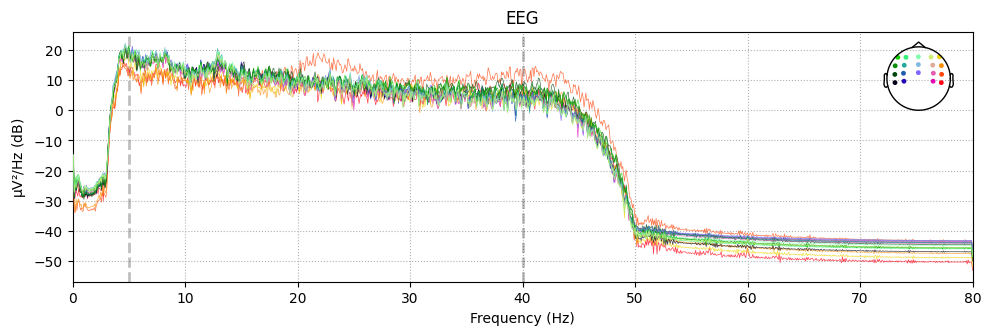

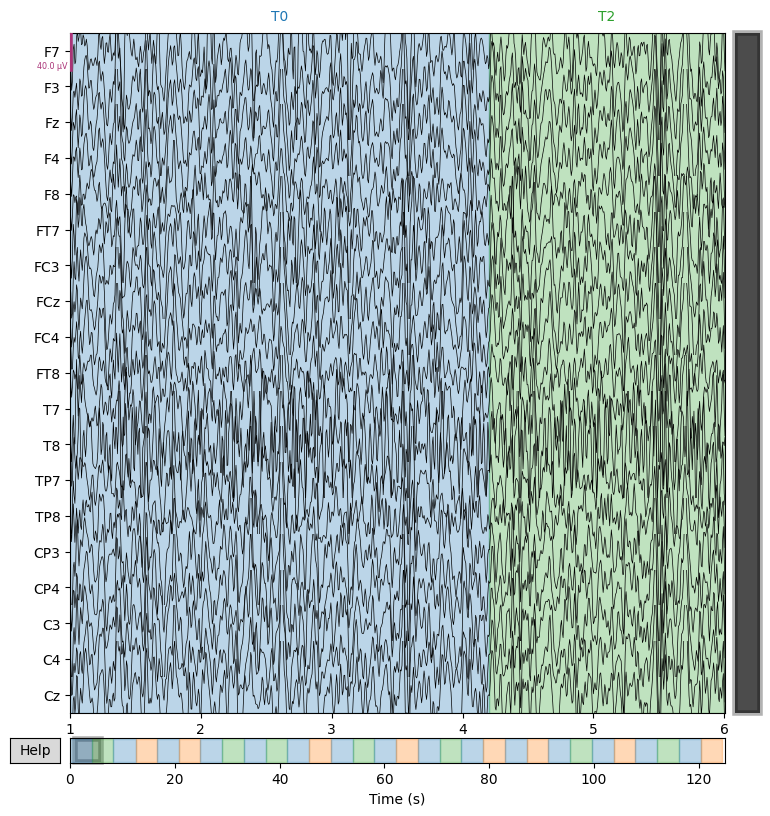

In [ ]:
h_edf_filter = h_edf.copy().filter(low_cut, hi_cut)
print("Healthy filtered data psd:")
plot_psd_and_time(h_edf_filter)

Stroke filtered data psd:


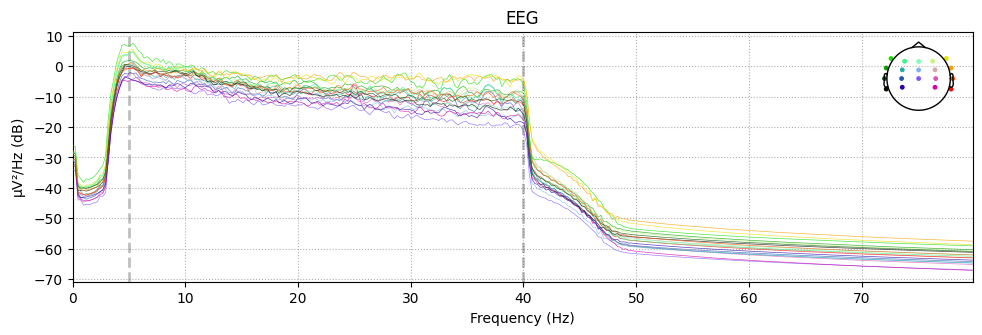

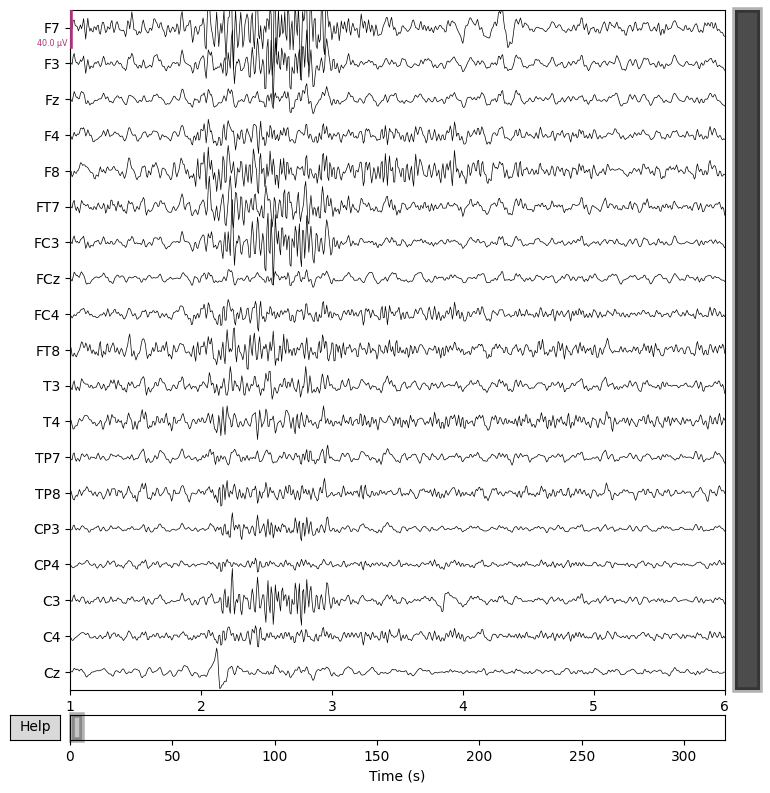

In [ ]:
s_edf_filter = s_edf.copy().filter(low_cut, hi_cut)
print("Stroke filtered data psd:")
plot_psd_and_time(s_edf_filter)

### ICA

In [ ]:
# set up and fit the ICA
def fit_and_plot_ICA(raw, n_components=10):
  ica = mne.preprocessing.ICA(n_components=10, random_state=97, max_iter=800)
  ica.fit(raw)
  ica.exclude = [1, 2]  # details on how we picked these are omitted here
  ica.plot_properties(raw, picks=ica.exclude)

Healthy ICA:


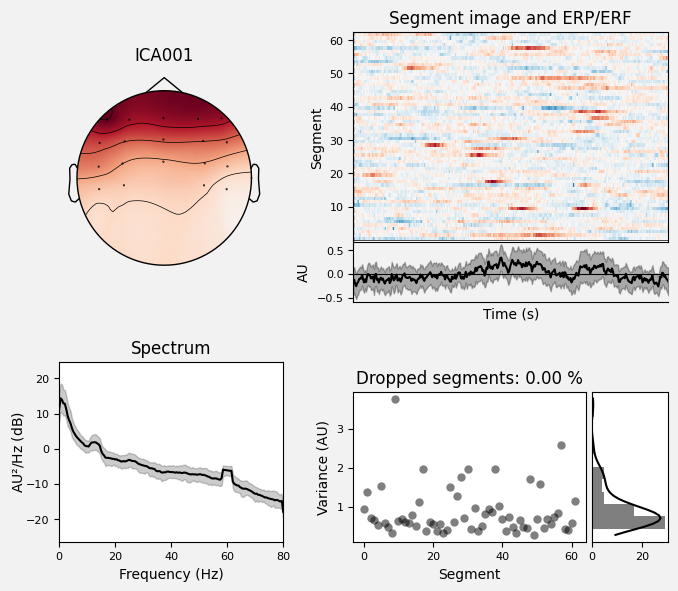

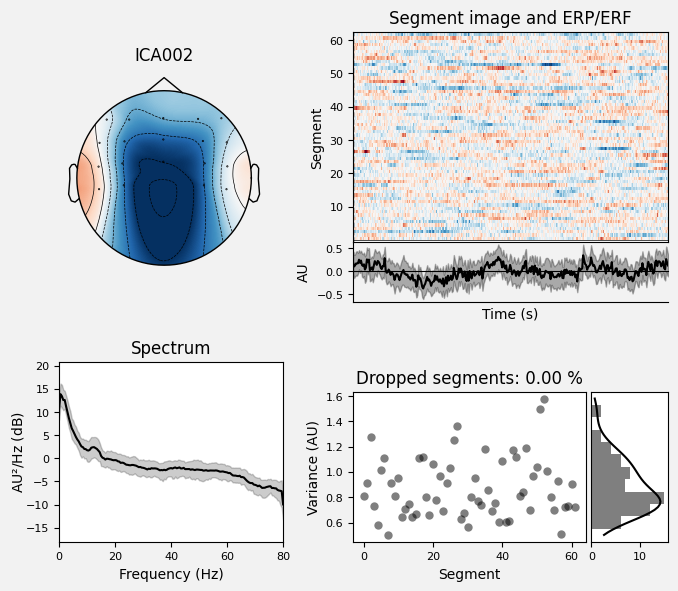

In [ ]:
print("Healthy ICA:")
fit_and_plot_ICA(h_edf)

Stroke ICA:


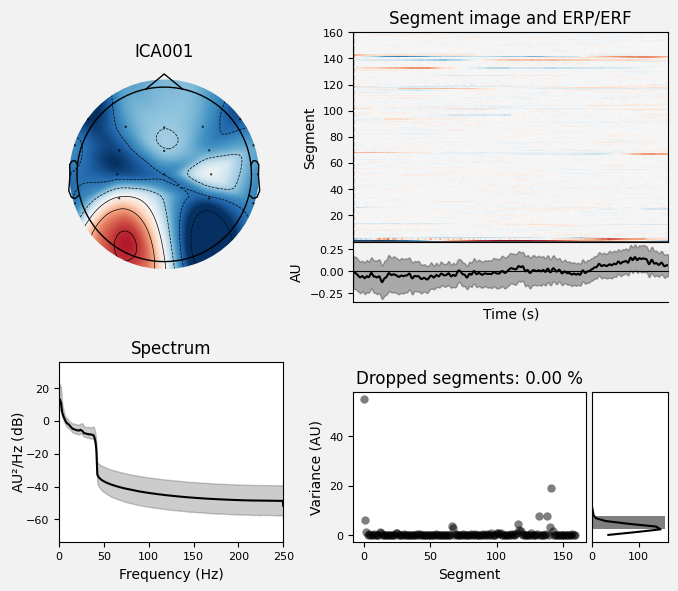

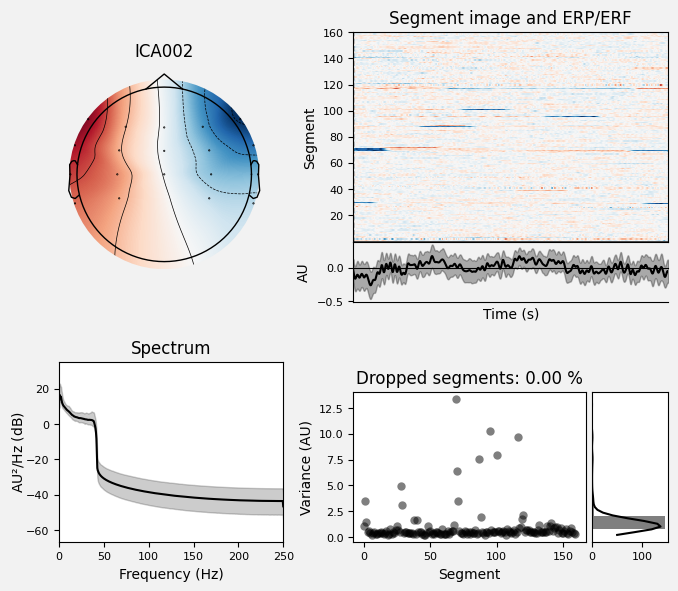

In [ ]:
print("Stroke ICA:")
fit_and_plot_ICA(s_edf)

Stroke filtered ICA:


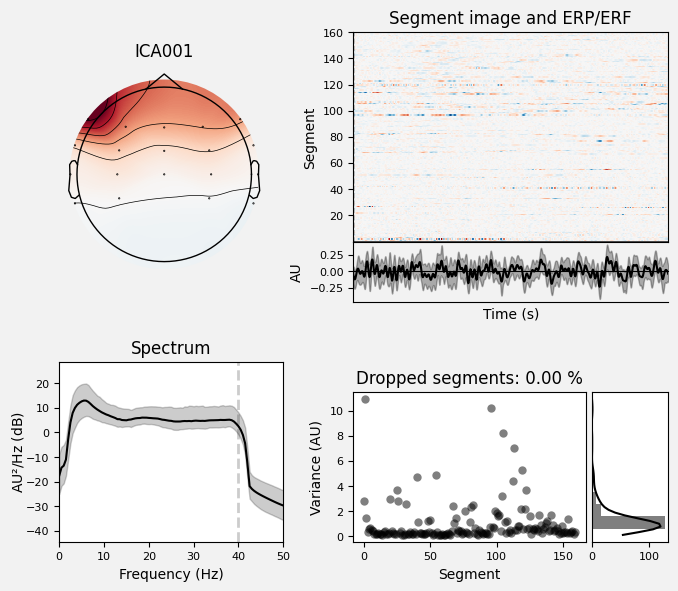

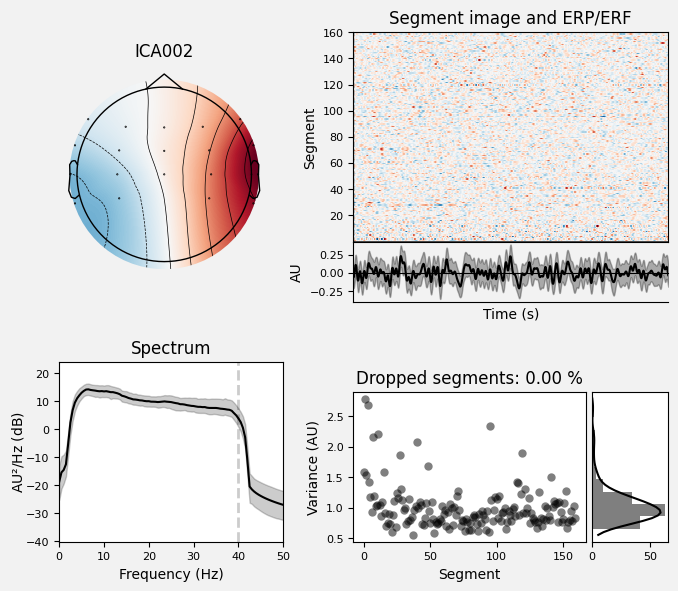

In [ ]:
print("Stroke filtered ICA:")
fit_and_plot_ICA(s_edf_filter)

In [ ]:
# h_edf.plot(butterfly=True, start=1, duration=0.5)
# print()

### Plot single channels

In [ ]:
import matplotlib.pyplot as plt

def plot_edf_channel(raw, channel, start_time=None, end_time=None):
  fig, ax = plt.subplots(figsize=[15, 5])
  ax.plot(raw.get_data(picks=channel, tmin=start_time, tmax=end_time).T)
  plt.show()

ValueError: ignored

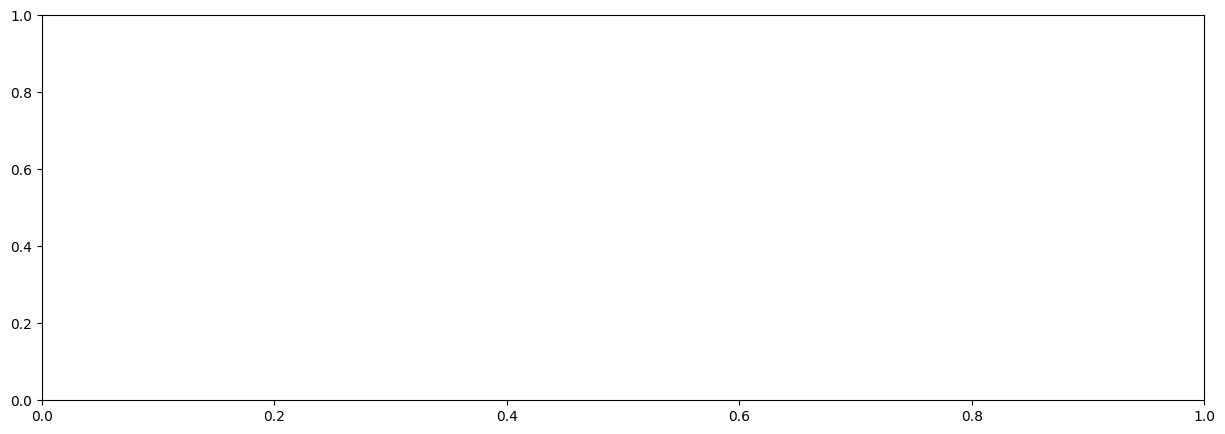

In [ ]:
channel = "Cz"
plot_edf_channel(h_edf, channel.ljust(4, "."), start_time=None, end_time=None)
plot_edf_channel(s_edf, channel, start_time=None, end_time=None)

In [ ]:
channel = "Cz"
plot_edf_channel(h_edf, channel.ljust(4, "."), start_time=2, end_time=6)
plot_edf_channel(s_edf, channel, start_time=4, end_time=8)

# Processed EEG Plots

### Data loading

In [ ]:
subjects=[1]

h_dataset = EEGDataset(healthy_processed_data_path, subjects=subjects, shuffle=False)
s_dataset = EEGDataset(stroke_preprocessed_data_path, subjects=subjects, shuffle=False)

print("Healthy dataset shape:", h_dataset.data.shape)
print("Stroke dataset shape:", s_dataset.data.shape)

----
Creating dataset for 1 subjects...


<ipython-input-4-1ffc25a616b2>:34: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels = torch.tensor(np.concatenate(labels_list).astype(np.long))


Dataset created:
Data shape: torch.Size([45, 1, 19, 640])
Labels shape: torch.Size([45])
----
----
Creating dataset for 1 subjects...
Dataset created:
Data shape: torch.Size([80, 1, 19, 640])
Labels shape: torch.Size([80])
----
Healthy dataset shape: torch.Size([45, 1, 19, 640])
Stroke dataset shape: torch.Size([80, 1, 19, 640])


In [ ]:
idx = 0
h_eeg = h_dataset[idx][0][0] # trial number, data, skipping shape 1
s_eeg = s_dataset[idx][0][0]

### Topographic Maps

Healthy subject topomap:


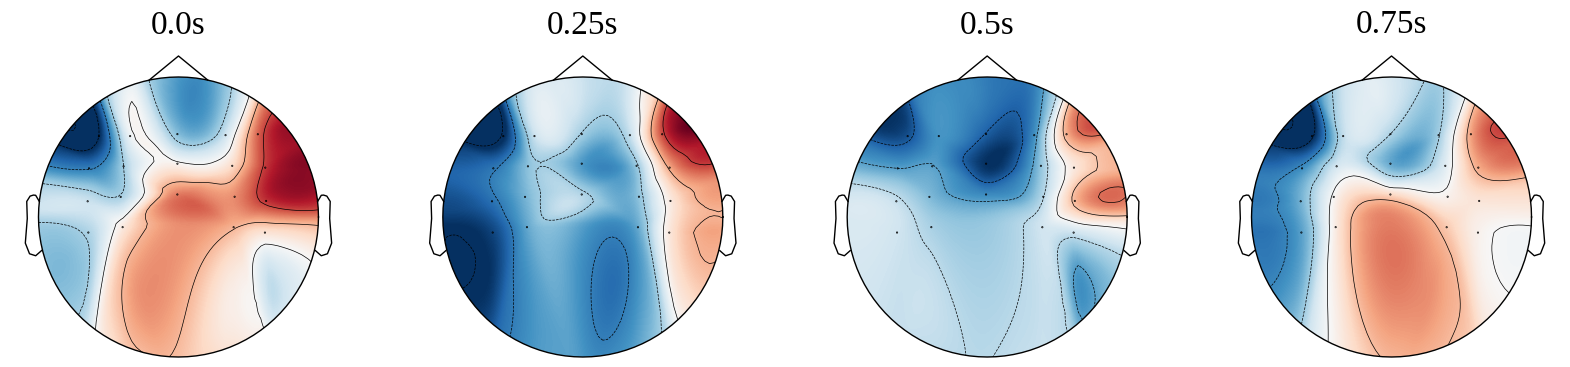


Stroke subject topomap:


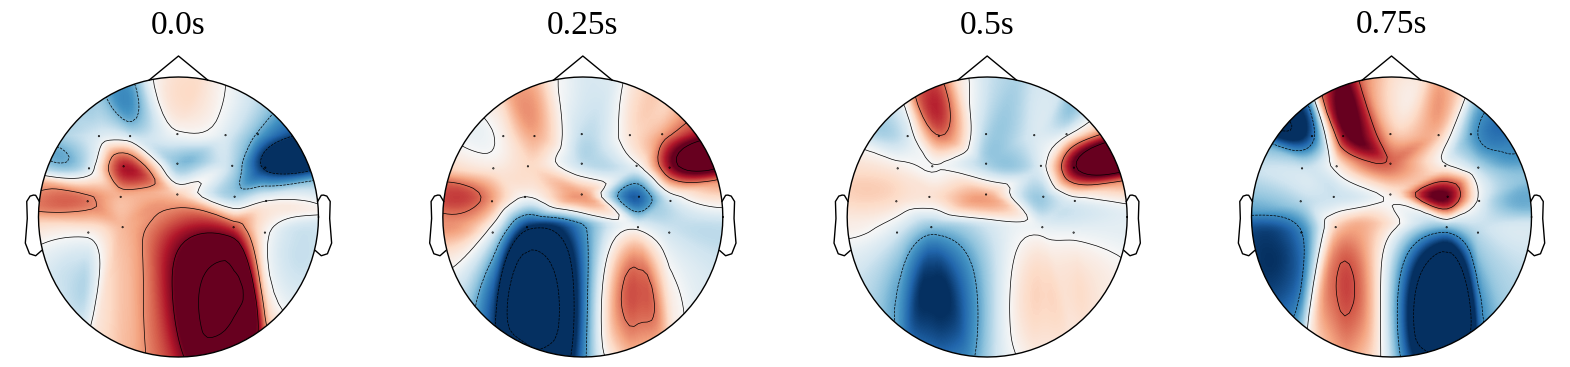

In [ ]:
print("Healthy subject topomap:")
img = plot_raw_topomap(h_eeg, channel_list=channels_for_plotting, sampling_rate=sampling_rate)
print()
print("Stroke subject topomap:")
img = plot_raw_topomap(s_eeg, channel_list=channels_for_plotting, sampling_rate=sampling_rate)

### Stroke monatge

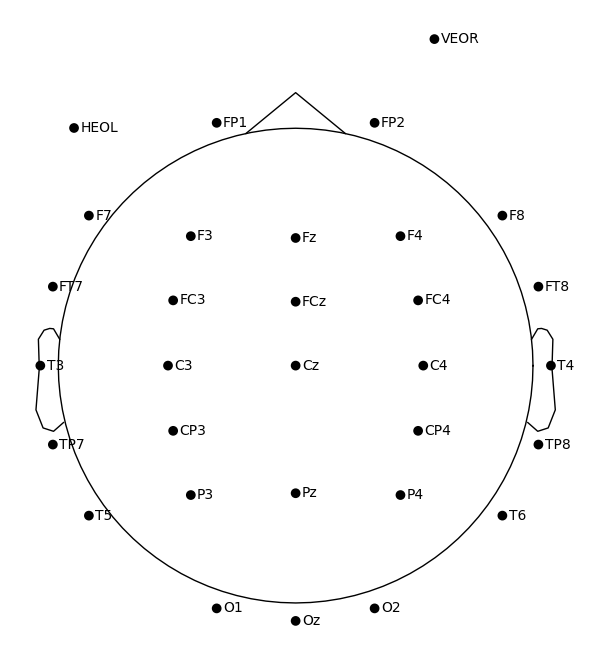

In [ ]:
s_montage = mne.channels.read_custom_montage(montage_file)
s_montage.plot()
print()

### Timeseries

Healthy subject signal:


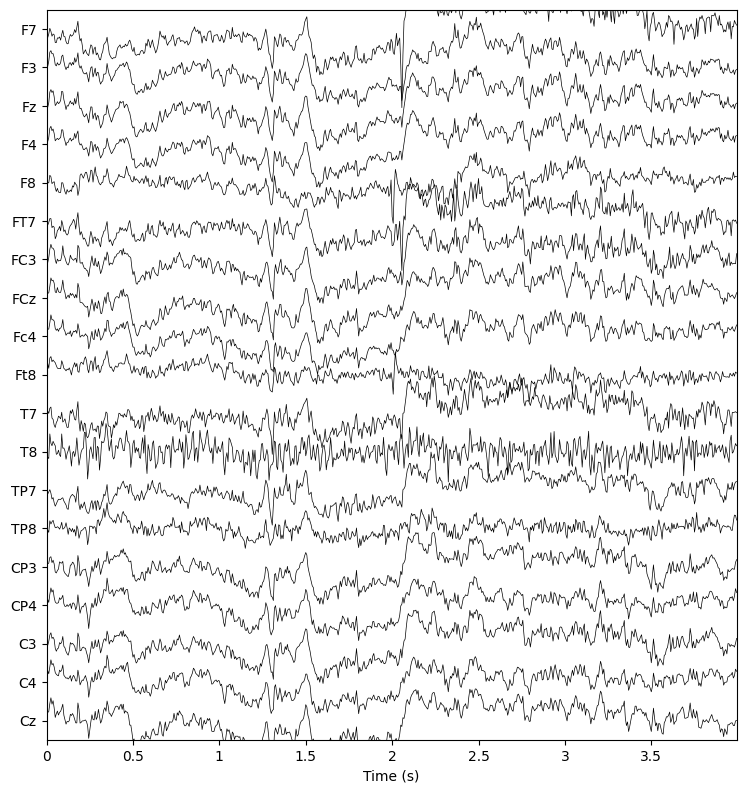


Stroke subject signal:


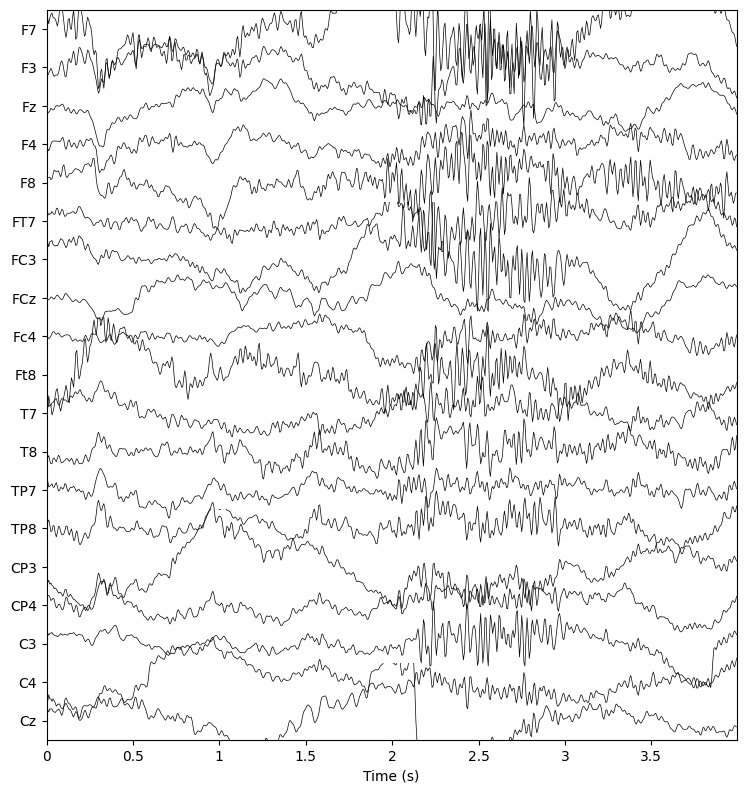

In [ ]:
print("Healthy subject signal:")
img = plot_signal(h_eeg, channel_list=channels_for_plotting, sampling_rate=sampling_rate)
print()
print("Stroke subject signal:")
img = plot_signal(s_eeg, channel_list=channels_for_plotting, sampling_rate=sampling_rate, montage=s_montage)